## Week 6 Assignment: end to end dependencies: Changing Data Distribution and seeing impact on Model Metrics and Visualizing Outcomes

## **1. Introduction**


This project aims to develop a fitness dashboard with my KPIs using fitbit data 

## **2. Domain Understanding**

Project objectives: 
* Visualise how lockdown impacted my health and fitness statistics. 
* Find a model that accurately predicts calories burned (KPI). 
* Create a custom fitness dashboard. 

In [ ]:
#Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import HTML


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set(style="darkgrid")
from scipy.stats import norm
from scipy import stats
import pylab 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Read the fit bit data from google drive

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/data/fitbit_data.csv')

data = data.rename(columns={'dateTime': 'ActivityDate'})
data['ActivityDate'] = pd.to_datetime(data['ActivityDate'], errors='coerce')


## **3. Data Understanding**
### **3.1 Overview**

The downloaded data from Fitbit gave me 380 days of data.
Each feature was a separate file which I merged.

* `Calories` amount of calories burned that day
* `Sedentary minutes`, basically the numbers of minutes you are sitting or lying down that day.
* `Moderately active minutes` & `Very active minutes` on the Fitbit dashboard these are added together and referred to as Active minutes. To earn active minute's you have to go through 10 minutes or more of continuous moderate-to-intense activity.
* `Lightly active minutes` the minutes between sedentary and moderately/very active. 
* `Distance` the total distance travelled in cm.
* `Steps` number of steps taken that day.

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        940 non-null    int64         
 1   ActivityDate              940 non-null    datetime64[ns]
 2   TotalSteps                940 non-null    int64         
 3   TotalDistance             940 non-null    float64       
 4   TrackerDistance           940 non-null    float64       
 5   LoggedActivitiesDistance  940 non-null    float64       
 6   VeryActiveDistance        940 non-null    float64       
 7   ModeratelyActiveDistance  940 non-null    float64       
 8   LightActiveDistance       940 non-null    float64       
 9   SedentaryActiveDistance   940 non-null    float64       
 10  VeryActiveMinutes         940 non-null    int64         
 11  FairlyActiveMinutes       940 non-null    int64         
 12  LightlyActiveMinutes  

The Fitbit data begins 9th January 2020. (Pre-lockdown)

In [ ]:
print(data.head(1).round(0))

           Id ActivityDate  ...  SedentaryMinutes  Calories
0  1503960366   2020-04-12  ...               728      1985

[1 rows x 15 columns]


The data ends 22nd January 2021- (In- Lockdown)

In [ ]:
print(data.tail(1).round(0))

             Id ActivityDate  ...  SedentaryMinutes  Calories
939  8877689391   2020-05-12  ...               770      1849

[1 rows x 15 columns]


### **3.2 Cleaning**

Checking for missing values below. There are missing values for some of the minute features.

In [ ]:
print(data.isnull().sum())

Id                          0
ActivityDate                0
TotalSteps                  0
TotalDistance               0
TrackerDistance             0
LoggedActivitiesDistance    0
VeryActiveDistance          0
ModeratelyActiveDistance    0
LightActiveDistance         0
SedentaryActiveDistance     0
VeryActiveMinutes           0
FairlyActiveMinutes         0
LightlyActiveMinutes        0
SedentaryMinutes            0
Calories                    0
dtype: int64


There are zero values present for `Distance`,`Steps` and the minute features seen below.

In [ ]:
print(data.describe().round(0))

                 Id  TotalSteps  ...  SedentaryMinutes  Calories
count  9.400000e+02       940.0  ...             940.0     940.0
mean   4.855407e+09      7638.0  ...             991.0    2304.0
std    2.424805e+09      5087.0  ...             301.0     718.0
min    1.503960e+09         0.0  ...               0.0       0.0
25%    2.320127e+09      3790.0  ...             730.0    1828.0
50%    4.445115e+09      7406.0  ...            1058.0    2134.0
75%    6.962181e+09     10727.0  ...            1230.0    2793.0
max    8.877689e+09     36019.0  ...            1440.0    4900.0

[8 rows x 14 columns]


As seen above, there are missing values in the minute features. 
Also, the minimum value is zero for several features.
Checking the zero values first below.



In [ ]:
data.loc[data['LightlyActiveMinutes'] == 0]

Id ActivityDate  ...  SedentaryMinutes  Calories
30   1503960366   2020-05-12  ...              1440         0
104  1844505072   2020-04-24  ...              1440      1347
105  1844505072   2020-04-25  ...              1440      1347
106  1844505072   2020-04-26  ...              1440      1347
112  1844505072   2020-05-02  ...              1440      1348
..          ...          ...  ...               ...       ...
904  8792009665   2020-05-06  ...              1440      1688
905  8792009665   2020-05-07  ...              1440      1688
906  8792009665   2020-05-08  ...              1440      1688
907  8792009665   2020-05-09  ...              1440      1688
908  8792009665   2020-05-10  ...                48        57

[84 rows x 15 columns]

 I added each minute feature together and subtracted from 1440. This new feature was called `Missing`. 

In [ ]:
#Checking to see if minutes add up to 1440. 
data['TotalMinutes'] = data['LightlyActiveMinutes'] +data['FairlyActiveMinutes'] +data['SedentaryMinutes'] +data['VeryActiveMinutes']
data['Missing'] = data['TotalMinutes'] - 1440

def complete(x):

    if (x == 1440):
        return 'Yes'
    else:
        return 'No'

data['complete'] = data['TotalMinutes'].apply(complete)

data['complete'].value_counts()

Yes    478
No     462
Name: complete, dtype: int64

There are 41 days where total minutes equal 1,440 minutes. However 16 of these are days were I registered zero active minutes, distance travel and steps taken. So I replaced these days with NaNs. For the days were the total number of minutes total 1,440 minutes, I found the average proportion for each minute feature. Form the this we see that sedentary accounts for on average 91% of the 1,440 minutes each day. 

In [ ]:
#First, address those 16 days. drop all values for those days. 
c = ['Calories', 'LightlyActiveMinutes','FairlyActiveMinutes','SedentaryMinutes','VeryActiveMinutes', 'TotalDistance','TotalSteps']
data[c] = data[c].mask(data['SedentaryMinutes'] == 1440)

#Rerun this to reflect the changing of the 16 days.
data['Total minutes'] = data['LightlyActiveMinutes'] +data['FairlyActiveMinutes'] +data['SedentaryMinutes'] +data['VeryActiveMinutes']
data['Missing'] = data['Total minutes'] - 1440

def complete(x):

    if (x == 1440):
        return 'Yes'
    else:
        return 'No'

data['complete'] = data['Total minutes'].apply(complete)

#Investigating the days where each of the minute features
#seperate these days into a datframe 
total = data['complete'] == 'Yes'
total_1 = data.loc[total]
total_1 = total_1.copy()

total_1['sed_per'] = total_1['SedentaryMinutes'] / 1440

total_1['lig_per'] = total_1['LightlyActiveMinutes'] / 1440

total_1['mod_per'] = total_1['FairlyActiveMinutes'] / 1440

total_1['very_per'] = total_1['VeryActiveMinutes'] / 1440

print(total_1[['sed_per']].mean().round(4))
print(total_1[['lig_per']].mean().round(4)) 
print(total_1[['mod_per']].mean().round(4)) 
print(total_1[['very_per']].mean().round(4)) 

sed_per    0.8302
dtype: float64
lig_per    0.1457
dtype: float64
mod_per    0.0081
dtype: float64
very_per    0.0159
dtype: float64


Using the proportions found assigned the unaccounted minutes from `Missing` to each of the minute features.  

In [ ]:
data['sed_per'] = (data['Missing'] * -0.9071).round(0)
data['lig_per'] = (data['Missing'] * -0.0585).round(0)
data['mod_per'] = (data['Missing'] * -0.0073).round(0)
data['very_per'] = (data['Missing'] * -0.0271).round(0)

data['per_tot'] = data['sed_per']+ data['lig_per'] + data['mod_per']  +data['very_per'] 
data['diff'] = data['per_tot'] + data['Missing']


#Disperse these minutes to each minute feature
data['LightlyActiveMinutes'] = data['LightlyActiveMinutes'] + data['lig_per'] 
data['FairlyActiveMinutes'] = data['FairlyActiveMinutes'] + data['mod_per']
data['SedentaryMinutes'] = data['SedentaryMinutes']  + data['sed_per']
data['VeryActiveMinutes'] = data['VeryActiveMinutes'] + data['very_per'] 
data['SedentaryMinutes'] = data['SedentaryMinutes'] - data['diff']
data['recheck'] = data['LightlyActiveMinutes'] +data['FairlyActiveMinutes'] +data['SedentaryMinutes'] +data['VeryActiveMinutes']
#dropping 
data=data.drop(['Missing','complete','Total minutes', 'per_tot' , 'sed_per', 'lig_per','mod_per','very_per','diff','recheck'],axis=1) 

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        940 non-null    int64         
 1   ActivityDate              940 non-null    datetime64[ns]
 2   TotalSteps                861 non-null    float64       
 3   TotalDistance             861 non-null    float64       
 4   TrackerDistance           940 non-null    float64       
 5   LoggedActivitiesDistance  940 non-null    float64       
 6   VeryActiveDistance        940 non-null    float64       
 7   ModeratelyActiveDistance  940 non-null    float64       
 8   LightActiveDistance       940 non-null    float64       
 9   SedentaryActiveDistance   940 non-null    float64       
 10  VeryActiveMinutes         861 non-null    float64       
 11  FairlyActiveMinutes       861 non-null    float64       
 12  LightlyActiveMinutes  

Next to replaced the NaNs, I created features for the day of the week and lockdown status. 

In [ ]:

#Create a feature for each day of the week
data['Day of the week'] = data['ActivityDate'].dt.day_name()
data['Day of the week'] = data['Day of the week'].replace('Monday', 'Mon')
data['Day of the week'] = data['Day of the week'].replace('Tuesday', 'Tues')
data['Day of the week'] = data['Day of the week'].replace('Wednesday', 'Wed')
data['Day of the week'] = data['Day of the week'].replace('Thursday', 'Thurs')
data['Day of the week'] = data['Day of the week'].replace('Friday', 'Fri')
data['Day of the week'] = data['Day of the week'].replace("Saturday", "Sat")
data['Day of the week'] = data['Day of the week'].replace("Sunday", "Sun")
#Create a feature for if its the lockdown
def lockdown(x):

    if (x >= pd.to_datetime('2020-03-27')) & (x <=pd.to_datetime('2020-05-01')):
        return 'No'
    # elif (x >= pd.to_datetime('2015-10-22')) & (x <=pd.to_datetime('2016-04-30')):
    #     return 'Yes'
    # elif (x >=pd.to_datetime('2015-12-24')):
    #     return 'Yes'
    else:
        return 'Yes'

data['In lockdown'] = data['ActivityDate'].apply(lockdown)

In [ ]:
data['In lockdown'].unique()

array(['No', 'Yes'], dtype=object)

Missing values for each feature were filled with the average value based for that day of the week and if we were in lockdown or not. 

In [ ]:
#Filling in missing values
data['Calories'] = data.groupby(['In lockdown','Day of the week'])['Calories'].apply(lambda x: x.fillna(x.mean()))
data['LightlyActiveMinutes'] = data.groupby(['In lockdown','Day of the week'])['LightlyActiveMinutes'].apply(lambda x: x.fillna(x.mean()))
data['FairlyActiveMinutes'] = data.groupby(['In lockdown','Day of the week'])['FairlyActiveMinutes'].apply(lambda x: x.fillna(x.mean()))
data['SedentaryMinutes'] = data.groupby(['In lockdown','Day of the week'])['SedentaryMinutes'].apply(lambda x: x.fillna(x.mean()))
data['VeryActiveMinutes'] = data.groupby(['In lockdown','Day of the week'])['VeryActiveMinutes'].apply(lambda x: x.fillna(x.mean()))
data['TotalSteps'] = data.groupby(['In lockdown','Day of the week'])['TotalSteps'].apply(lambda x: x.fillna(x.mean()))
data['TotalDistance'] = data.groupby(['In lockdown','Day of the week'])['TotalDistance'].apply(lambda x: x.fillna(x.mean()))

#delete
del c, total, total_1

### **3.2 EDA**

The target feature is calories burned, the plot below shows it is pretty close to a normal distribution.

Text(0.5, 1.0, 'Calories Burned Histogram (kcal)')

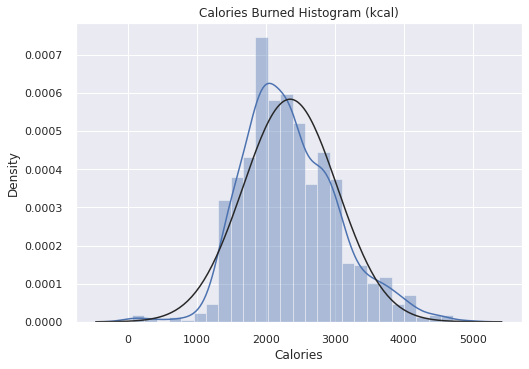

In [ ]:
#Target Calories
#histogram and normal probability plot
sns.distplot(data['Calories'], fit=norm).set_title('Calories Burned Histogram (kcal)')

Average calories burned over the period was 2,688.

In [ ]:
#stats
print(data['Calories'].describe().round(0))

count     940.0
mean     2350.0
std       684.0
min        52.0
25%      1884.0
50%      2280.0
75%      2784.0
max      4900.0
Name: Calories, dtype: float64


The scatterplot below illustrates the target and features relationships. I converted 'Distance' from cm to km to make the plot clearer.
A clear positive linear relationship between calories and steps & distance.
The three active minutes are much more dispersed and positive. The sedentary is dispersed and negative. There is a strong linear relationship between `Distance` & `Steps`. 

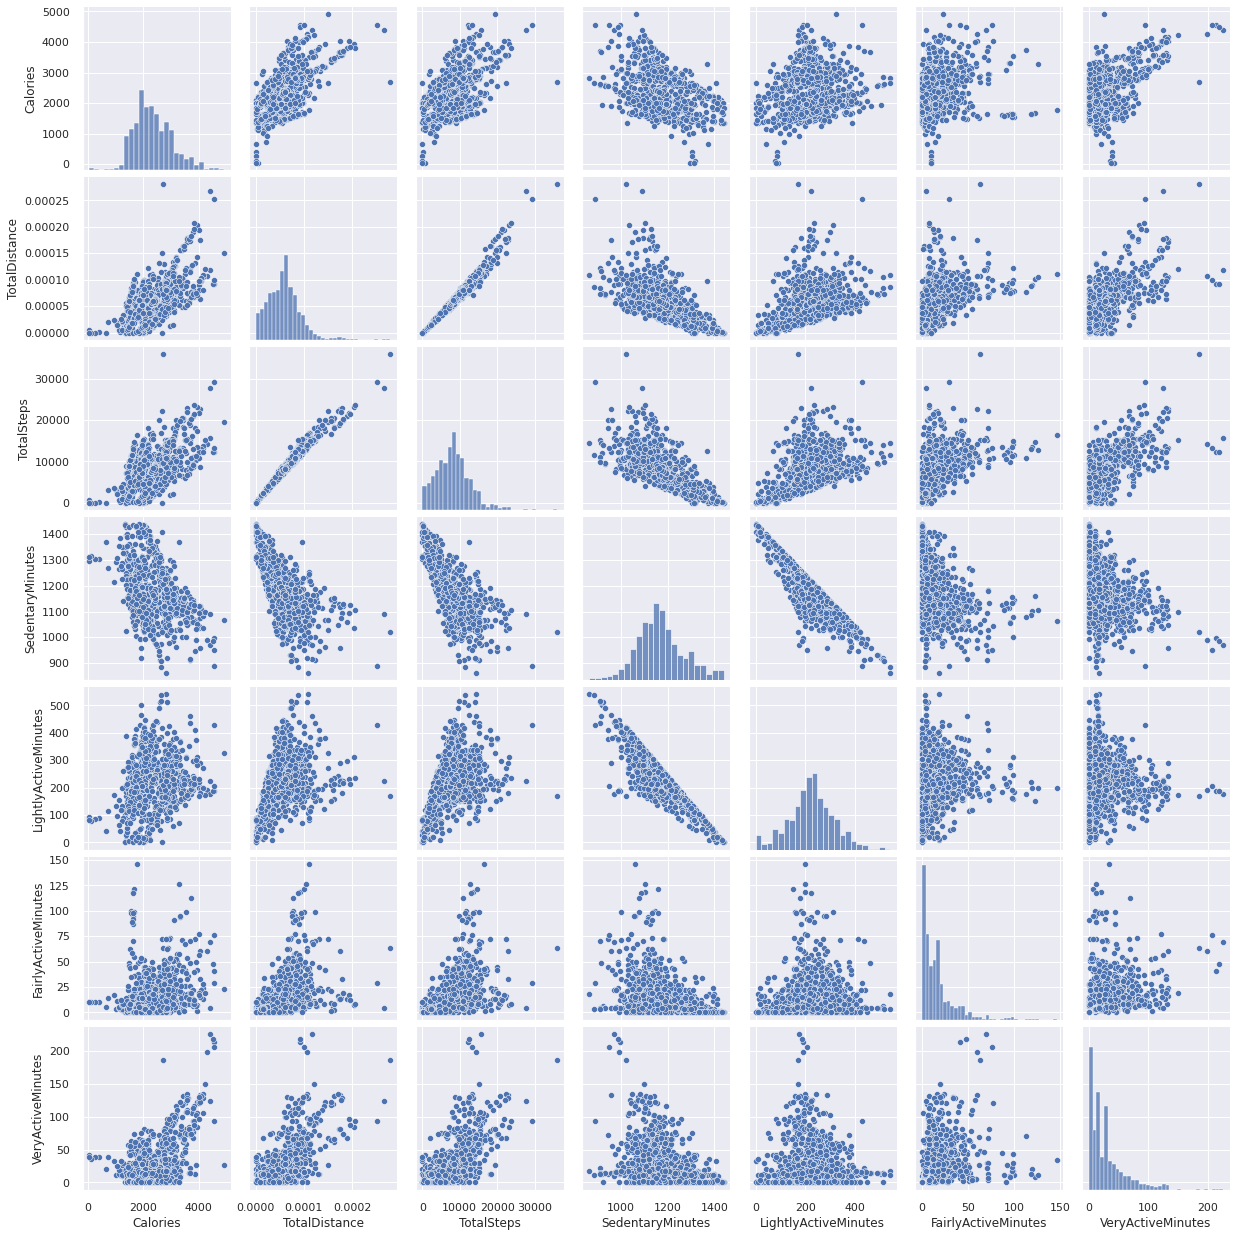

In [ ]:
#Scatter plot
#Changing TotalDistance to km
def dist(x):
    return (x)/100000
data[['TotalDistance']] = data[['TotalDistance']].apply(dist)

sns.set()
cols = ['Calories', 'TotalDistance', 'TotalSteps', 'SedentaryMinutes', 'LightlyActiveMinutes', 'FairlyActiveMinutes', 'VeryActiveMinutes']
sns.pairplot(data[cols])
plt.show()


Looking at the impacts of lockdown on calories burned. 
The bar plot below shows that of the **380** days of data the country was in lockdown for **49%** of them.

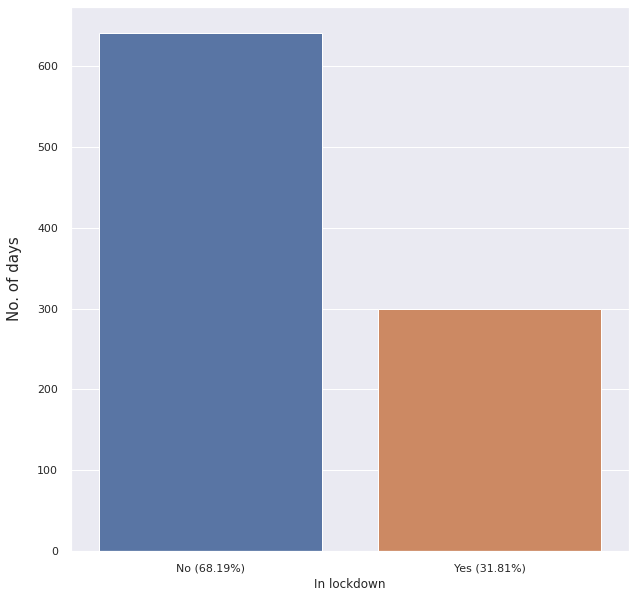

In [ ]:
Yes = data['In lockdown'].value_counts()['Yes']
No = data['In lockdown'].value_counts()['No']
Yes_per = Yes / data.shape[0] * 100
No_per = No / data.shape[0] * 100

plt.figure(figsize=(10, 10))
sns.countplot(data['In lockdown'])
plt.ylabel('No. of days', size=15, labelpad=15)
plt.xticks((0, 1), ['No ({0:.2f}%)'.format(No_per), 'Yes ({0:.2f}%)'.format(Yes_per)])
plt.show()

In [ ]:
#Filter by Lockdown
print(data.groupby(['In lockdown']).mean().round(0))
lock = data.groupby(['In lockdown']).mean().round(0)

order = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat","Sun"]

                       Id  TotalSteps  ...  Calories  TotalMinutes
In lockdown                            ...                        
No           4.879704e+09      8385.0  ...    2377.0        1235.0
Yes          4.803321e+09      8062.0  ...    2294.0        1183.0

[2 rows x 15 columns]


The stats show a negative impact across all fitness metrics. 

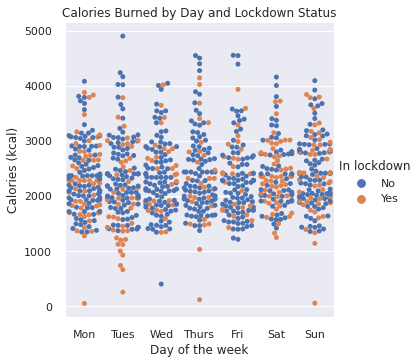

In [ ]:
swarmplot_1 = sns.catplot(x='Day of the week', y="Calories", hue="In lockdown", kind="swarm", data=data, order=order)
ax = plt.gca()
ax.set_title('Calories Burned by Day and Lockdown Status')
ax.set_ylabel('Calories (kcal)')
print(swarmplot_1)

The times were I burnt fewer calories nearly all occurred during the lockdown, 5 out of 7 days. While days I burnt the most calories generally happened on days, not in lockdown.   

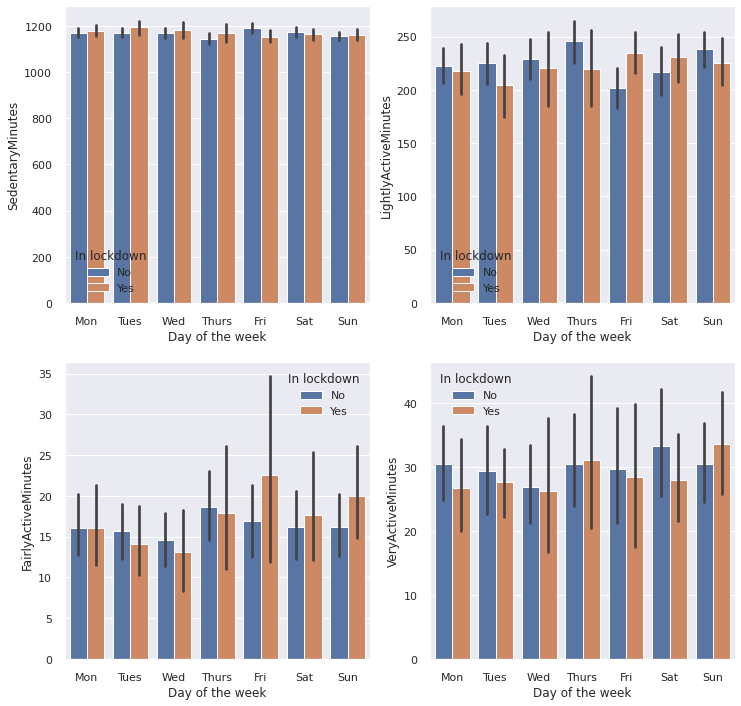

In [ ]:
#bar plots minutes
plt.figure(figsize=[12,12])
plt.subplot(2,2,1)
b1 = sns.barplot(x="Day of the week", y="SedentaryMinutes", hue="In lockdown",data=data, order=order)
plt.subplot(2,2,2)
b2=sns.barplot(x="Day of the week", y="LightlyActiveMinutes", hue="In lockdown",data=data, order=order)
plt.subplot(2,2,3)
b3=sns.barplot(x="Day of the week", y="FairlyActiveMinutes", hue="In lockdown",data=data, order=order)
plt.subplot(2,2,4)
b4 = sns.barplot(x="Day of the week", y="VeryActiveMinutes", hue="In lockdown",data=data, order=order)

Lockdown had the biggest impact on my moderately active minutes more than any other minute feature. 

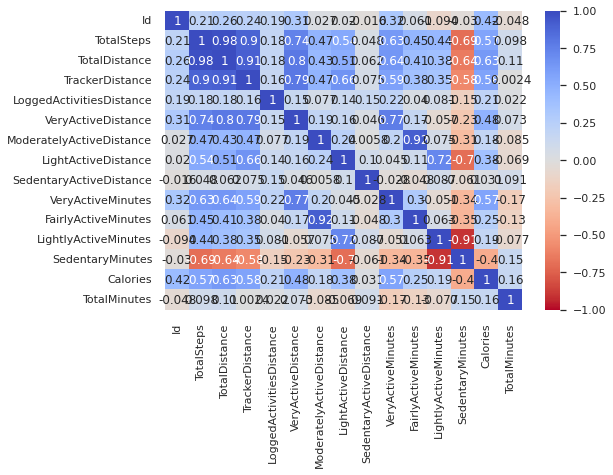

In [ ]:
#Correlation 
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm_r')

Viewing the correlation matrix Calories is strngly coreelated with `Distance` & `Steps`. We saw in the scatterplot that these two are highly correlated. This could cause some issues with our models latter. 

## **4. Data Preparation**

### **4.1 Feature Engineering**




To fix the issues above:

* create a new feature for average steps per meter.
* feature for weekday or weekend.
* combined very active and moderately active similar to the Fitbit dashboard.

In [ ]:
#Create a feature for if its the weekend or weekday.
def week_status(x):
    
    if (x == 'Sat'):
        return 'Weekend'
    elif (x == 'Sun'):
        return 'Weekend'
    else:
        return 'Weekday'

data['Week_status'] = data['Day of the week'].apply(week_status)
#on fitbit dashboard very active and moderately active are added together and reported as Active minutes
data['Active minutes'] = data['VeryActiveMinutes'] + data['FairlyActiveMinutes']
#Avg TotalSteps per meter
data['Avg steps per km'] = data['TotalSteps'] / (data['TotalDistance'])

#dropping
data=data.drop(['VeryActiveMinutes', 'FairlyActiveMinutes'],axis=1)  
data=data.drop(['TotalSteps', 'TotalDistance'],axis=1)  

Rechecking the correlations again, things look better.  

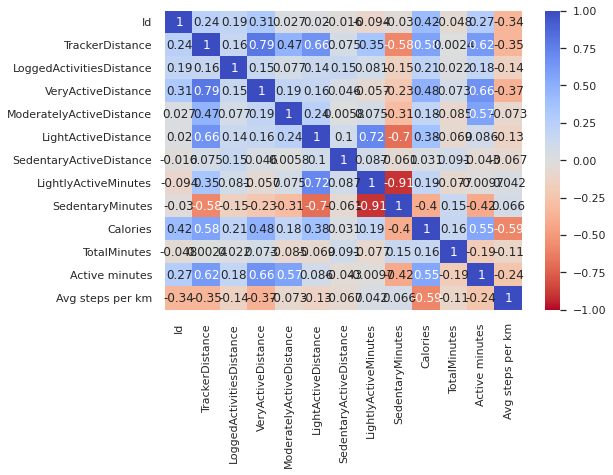

In [ ]:
#Correlation
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm_r')

In [ ]:
#index date
data = data.set_index('ActivityDate')
# Print the col
#Feature Transformation
#scikit-learn does not accept non-numerical features.
# Create dummy variables: data
data = pd.get_dummies(data, drop_first=True)

# a list of the feature names for later
feature_names = ['LightlyActiveMinutes', 'SedentaryMinutes','Active minutes', 'Avg steps per km', 'Day of the week_Mon','Day of the week_Sat', 'Day of the week_Sun', 'Day of the week_Thurs', 'Day of the week_Tues', 'Day of the week_Wed', 'In lockdown_Yes','Week_status_Weekend'] 

In [ ]:
data.info()
#data.head(1000)
#np.any(np.isnan(data))
#data.dropna(how='any') 
#np.any(np.isnan(data))

#np.any(np.isnan(data))
#data['TotalSteps'].isnull().values.any()

#np.isfinite(data.all()) #and gets True
#print(data.isnull().sum())
# print(data.describe().round(0))
# print(data.isnull().sum())
# data.dropna(subset=['Avg steps per km'])
#np.nan_to_num(data['Avg steps per km'], copy=True, nan=0.0, posinf=0.0, neginf=0.0)
#data.loc[:, ~df.isna().cumsum(axis=1).any(axis=0)]
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0.0, inplace=True)
data['Avg steps per km'].unique()

#np.isnan(data)





<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 940 entries, 2020-04-12 to 2020-05-12
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   TrackerDistance           940 non-null    float64
 2   LoggedActivitiesDistance  940 non-null    float64
 3   VeryActiveDistance        940 non-null    float64
 4   ModeratelyActiveDistance  940 non-null    float64
 5   LightActiveDistance       940 non-null    float64
 6   SedentaryActiveDistance   940 non-null    float64
 7   LightlyActiveMinutes      940 non-null    float64
 8   SedentaryMinutes          940 non-null    float64
 9   Calories                  940 non-null    float64
 10  TotalMinutes              940 non-null    int64  
 11  Active minutes            940 non-null    float64
 12  Avg steps per km          935 non-null    float64
 13  Day of the week_Mon       940 non-null    uint

array([1.54847059e+08, 1.54017221e+08, 1.55192884e+08, 1.55445855e+08,
       1.55257356e+08, 1.49768518e+08, 1.51559951e+08, 1.56943318e+08,
       1.57844315e+08, 1.54873813e+08, 1.56998768e+08, 1.58971240e+08,
       1.56614668e+08, 1.56683670e+08, 1.56484642e+08, 1.48517608e+08,
       1.54208680e+08, 1.56377620e+08, 1.58627027e+08, 1.55682821e+08,
       1.51668383e+08, 1.56345758e+08, 1.55244753e+08, 1.58089894e+08,
       1.51419681e+08, 1.55538261e+08, 1.52887540e+08, 1.55725393e+08,
       1.57104247e+08, 1.57072569e+08, 1.40908070e+08, 1.53728815e+08,
       1.53999994e+08, 1.53834457e+08, 1.54081630e+08, 1.53868194e+08,
       1.52093598e+08, 1.42186238e+08, 1.53473686e+08, 1.53993807e+08,
       1.53728809e+08, 1.53664129e+08, 1.53837833e+08, 1.53822783e+08,
       1.53957354e+08, 1.53586954e+08, 1.53805145e+08, 1.54134081e+08,
       1.54193553e+08, 1.50558133e+08, 1.28501602e+08, 1.45131851e+08,
       1.53284671e+08, 1.53356649e+08, 1.53416148e+08, 1.54196428e+08,
      

**Latent Varaibles** 

Active minutes        
In lockdown_Yes      
  


## **5. Modelling**


Split the data set, 80% train data and 20% test data.
I used a multiple linear regression (MLR) model as a base model to compare the other two models two. 

In [ ]:
#Models
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Create training and test sets
# Create arrays for features and target variable

X =  StandardScaler().fit_transform(data.drop(columns ='Calories'))
y = data['Calories'].values

data.head()

X_train, X_test = X[0:int(len(X)*0.8)], X[int(len(X)*0.8):]
y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]


#LINEAR MODEL
# Create the regressor: reg
reg = LinearRegression()

# Fit the regressor to the training data
reg.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred_reg = reg.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg.score(X_test, y_test)))
rmse_reg = np.sqrt(mean_squared_error(y_test, y_pred_reg))
print("Root Mean Squared Error: {}".format(rmse_reg))
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred_reg)))


R^2: 0.5758451545945246
Root Mean Squared Error: 464.01209173142263
Mean absolute error: 365.38885096294064


The R squared for the MLR model is 57%. Next, I tried an out of the box Random Forest (RF) model. 

In [ ]:
SEED = 42 #random seed
#RANDOM FOREST Default
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(random_state= SEED)
rfr.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred_rfr = rfr.predict(X_test)

# Compute and print R^2, RMSE and MAE
print("R^2: {}".format(rfr.score(X_test, y_test)))
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print("Root Mean Squared Error: {}".format(rmse_rfr))
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred_rfr)))

R^2: 0.5994451669429222
Root Mean Squared Error: 450.91851683700486
Mean absolute error: 323.96434904204597


A slight improvement over the MLR model. Next, I tuned the hyperparameters for the RF model. 

In [ ]:
#TUNING
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[100,200,300,500,1000], 'max_depth': [3,5,7], 'max_features': [4,8,12], 'random_state': [SEED] }

test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(X_train, y_train)
    test_scores.append(rfr.score(X_test, y_test))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.6119054026551378 {'random_state': 42, 'n_estimators': 300, 'max_features': 12, 'max_depth': 7}


In [ ]:
#Evaluate performance

#Lastly, and as always, we want to evaluate performance of our best model to check 
#how well or poorly we are doing. 

# Create the random forest model and fit to the training data
rfr_2 = RandomForestRegressor(n_estimators=200, max_depth=7,max_features=12, random_state= SEED)
rfr_2.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred_rfr_2 = rfr_2.predict(X_test)

# Compute and print R^2, RMSE and MAE
print("R^2: {}".format(rfr_2.score(X_test, y_test)))
rmse_rfr_2 = np.sqrt(mean_squared_error(y_test, y_pred_rfr_2))
print("Root Mean Squared Error: {}".format(rmse_rfr_2))
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred_rfr_2)))

R^2: 0.6113843524152331
Root Mean Squared Error: 444.14750156897003
Mean absolute error: 313.26653447674295


Our tuned model performs worse than the out of the box one. Below we can see the feature importance. It looks like the day of the week feature isn't that important and may want to drop it. 

[7.90560087e-02 1.51234577e-01 2.25944149e-04 1.94337369e-02
 3.17918483e-02 2.80289195e-02 1.35013074e-03 2.95324103e-02
 5.20592650e-02 8.19499205e-02 8.67599103e-02 4.32213010e-01]
[11  1 10  9  0  8  4  7  5  3  6  2]
range(0, 12)


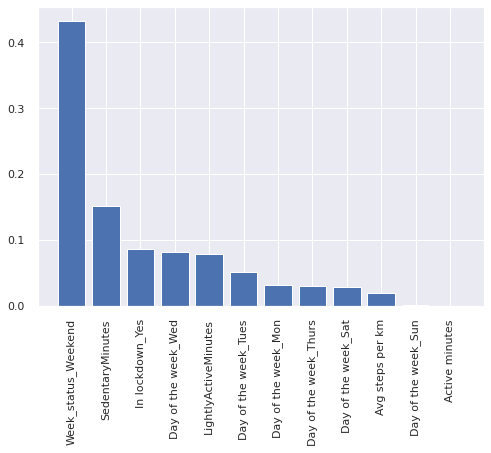

In [ ]:
#Random forest feature importances
# Get feature importances from our random forest model
importances = rfr_2.feature_importances_
importances = importances[:-8]
print(importances)

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
print(sorted_index)
x = range(len(importances))

print(x)

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

Next I will try a gradient boosting model

In [ ]:
#A gradient boosting model
#GRADIENT BOOSTING REGRESSOR DEFAULT
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model 
gbr = GradientBoostingRegressor(random_state= SEED)
gbr.fit(X_train, y_train)
# Predict on the test data: y_pred
y_pred_gbr = gbr.predict(X_test)
# Compute and print R^2, RMSE and MAE
print("R^2: {}".format(gbr.score(X_test, y_test)))
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
print("Root Mean Squared Error: {}".format(rmse_gbr))
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred_gbr)))

R^2: 0.6097021364463372
Root Mean Squared Error: 445.1077629647375
Mean absolute error: 323.69026473726495


Performs slightly better than MLR. I will tune it to see if I can increase performance. 

In [ ]:
#TUNING GRADIENT MODEL
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[100,200,300,500,1000], 'learning_rate': [0.01,0.05,0.1], 'max_features': [4,8,12], 'max_depth':[3,5,7], 'random_state': [SEED] }

test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    gbr.set_params(**g)  # ** is "unpacking" the dictionary
    gbr.fit(X_train, y_train)
    test_scores.append(gbr.score(X_test, y_test))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.718989732199806 {'random_state': 42, 'n_estimators': 1000, 'max_features': 4, 'max_depth': 3, 'learning_rate': 0.05}


In [ ]:
# Create GB model 
gbr_2 = GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.01, max_features = 8, max_depth = 5, random_state= SEED)
gbr_2.fit(X_train, y_train)
# Predict on the test data: y_pred
y_pred_gbr_2 = gbr_2.predict(X_test)
# Compute and print R^2, RMSE and MAE
print("R^2: {}".format(gbr_2.score(X_test, y_test)))
rmse_gbr_2 = np.sqrt(mean_squared_error(y_test, y_pred_gbr_2))
print("Root Mean Squared Error: {}".format(rmse_gbr_2))
print("Mean absolute error: {}".format(mean_absolute_error(y_test, y_pred_gbr_2)))

R^2: 0.6075463961758512
Root Mean Squared Error: 446.33530673071266
Mean absolute error: 313.07701134125796


The perfromance is increase over the out of the box model and its better than MLR but the tuned RF. An interesting finding from this model is that days of the week feature is important in this model. 

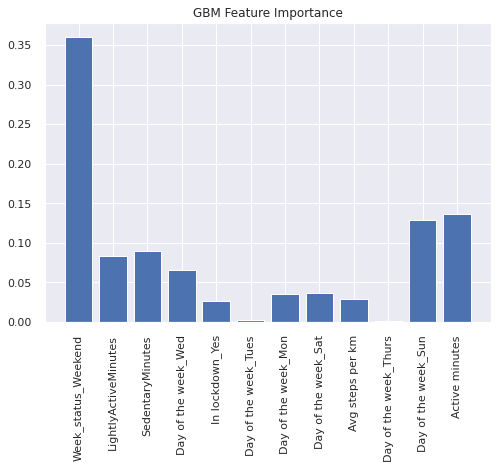

In [ ]:
#GRADIENT BOOSTINGfeature importances
features = data[feature_names]

# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr_2.feature_importances_
feature_importances = feature_importances[:-8]
# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(len(feature_importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, feature_importances[::-1], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.title('GBM Feature Importance')
plt.show()

Plotting the predicted calories over the actual calories in the test data below. It's close but could be better. 

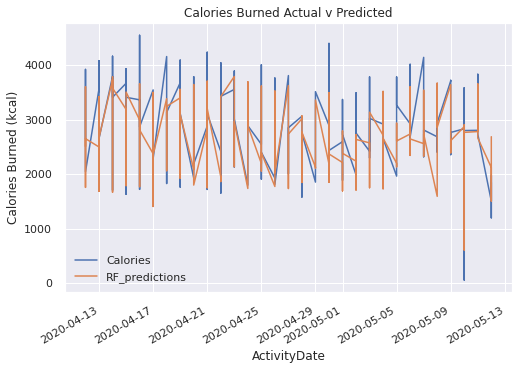

In [ ]:
#Plotting predictions against actual values
Y = data['Calories']
y_index_train, y_index_test = Y[0:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]
perdict = pd.DataFrame(y_pred_rfr_2,  columns=['RF_predictions'],    index=y_index_test.index)

results  = pd.concat([y_index_test, perdict], axis=1)

results.plot(y=['Calories','RF_predictions'])
plt.title('Calories Burned Actual v Predicted')
plt.ylabel('Calories Burned (kcal)')
plt.show()

# Muller Regressor loop with change in data distribution
## R2 score with Change in data distribution








In [ ]:

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.metrics import r2_score
def muellerregresssorloop(data,feat):


  kernel = DotProduct() + WhiteKernel()
  names = ["GradientBoostingRegressor","RandomForestRegressor","LinearRegression","SVR","DecisionTreeRegressor","AdaBoostRegressor","GaussianProcessRegressor"]
  regressors = [GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.01, max_features = feat, max_depth = 5, random_state= 42), RandomForestRegressor(n_estimators=200, max_depth=7,max_features=feat, random_state= 42), LinearRegression(), SVR(kernel='rbf', gamma='auto'), DecisionTreeRegressor(random_state = 0), AdaBoostRegressor(random_state=0, n_estimators=100), GaussianProcessRegressor(kernel=kernel,random_state=0)]
  #regressors = [GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.01, max_features = 8, max_depth = 5, random_state= 42), RandomForestRegressor(n_estimators=200, max_depth=7,max_features=12, random_state= 42), LinearRegression(), SVR(kernel='rbf', gamma='auto'), DecisionTreeRegressor(random_state = 0), AdaBoostRegressor(random_state=0, n_estimators=100), GaussianProcessRegressor(kernel=kernel,random_state=0)]

  X =  StandardScaler().fit_transform(data.drop(columns ='Calories'))
  y = data['Calories'].values

  X_train, X_test, y_train, y_test = \
      train_test_split(X, y, test_size=.2)

  # TODO (Apply): All cross-validation

  max_score = 0.0
  max_class = ''
  # iterate over regressors
  for name, clf in zip(names, regressors):
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      pred = clf.predict(X_train)
      r2 = r2_score(y_train, pred)
      print('R2 SCORE = %.2f,' %(r2))
      print('regressors = %s, Score (test, accuracy) = %.2f,' %(name, score))
      
      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name

  print(80*'-' )
  print('Best --> regressors = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  #plot the output of the various algorithms

# Change in data distribution for regressors

In [ ]:
df_ml = data[['Calories','Avg steps per km','VeryActiveDistance','TotalMinutes','In lockdown_Yes']].copy()
muellerregresssorloop(df_ml,4);

df_ml = data[['Calories','Avg steps per km','VeryActiveDistance','TotalMinutes','In lockdown_Yes']].copy()
muellerregresssorloop(df_ml,4);
 
df_ml = data[['TrackerDistance','LoggedActivitiesDistance','VeryActiveDistance','ModeratelyActiveDistance','LightActiveDistance','LightlyActiveMinutes','SedentaryMinutes','Calories','TotalMinutes','Active minutes','Avg steps per km','In lockdown_Yes']].copy()
muellerregresssorloop(df_ml,11);
 
df_ml = data[['TrackerDistance','LoggedActivitiesDistance','VeryActiveDistance','SedentaryMinutes','Calories','TotalMinutes','Active minutes','Avg steps per km','In lockdown_Yes']].copy()
muellerregresssorloop(df_ml,8);

muellerregresssorloop(data,20)



R2 SCORE = 0.94,
regressors = GradientBoostingRegressor, Score (test, accuracy) = 68.25,
R2 SCORE = 0.83,
regressors = RandomForestRegressor, Score (test, accuracy) = 70.74,
R2 SCORE = 0.34,
regressors = LinearRegression, Score (test, accuracy) = 3.75,
R2 SCORE = 0.04,
regressors = SVR, Score (test, accuracy) = 2.10,
R2 SCORE = 1.00,
regressors = DecisionTreeRegressor, Score (test, accuracy) = 41.76,
R2 SCORE = 0.40,
regressors = AdaBoostRegressor, Score (test, accuracy) = 42.95,
R2 SCORE = 0.01,
regressors = GaussianProcessRegressor, Score (test, accuracy) = -0.18,
--------------------------------------------------------------------------------
Best --> regressors = RandomForestRegressor, Score (test, accuracy) = 70.74
R2 SCORE = 0.94,
regressors = GradientBoostingRegressor, Score (test, accuracy) = 73.69,
R2 SCORE = 0.82,
regressors = RandomForestRegressor, Score (test, accuracy) = 69.72,
R2 SCORE = 0.31,
regressors = LinearRegression, Score (test, accuracy) = 20.45,
R2 SCORE = 0.04,

In [ ]:
# define the keras model
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
# X_train, X_test = X[0:int(len(X)*0.8)], X[int(len(X)*0.8):]
# y_train, y_test = y[0:int(len(y)*0.8)], y[int(len(y)*0.8):]
model.add(Dense(12, input_dim=20, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# fit the keras model on the dataset

#X.reshape(-1,940*20)
#print(y.shape)
model.fit(X, y, epochs=10, batch_size=10)

Epoch 1/10
94/94 [==============================] - 0s 859us/step - loss: -4536.1528 - accuracy: 0.0000e+00
Epoch 2/10
94/94 [==============================] - 0s 858us/step - loss: -13603.3955 - accuracy: 0.0000e+00
Epoch 3/10
94/94 [==============================] - 0s 940us/step - loss: -36246.1484 - accuracy: 0.0000e+00
Epoch 4/10
94/94 [==============================] - 0s 858us/step - loss: -84208.5312 - accuracy: 0.0000e+00
Epoch 5/10
94/94 [==============================] - 0s 900us/step - loss: -168280.5469 - accuracy: 0.0000e+00
Epoch 6/10
94/94 [==============================] - 0s 865us/step - loss: -299358.8438 - accuracy: 0.0000e+00
Epoch 7/10
94/94 [==============================] - 0s 901us/step - loss: -487611.0000 - accuracy: 0.0000e+00
Epoch 8/10
94/94 [==============================] - 0s 912us/step - loss: -742111.2500 - accuracy: 0.0000e+00
Epoch 9/10
94/94 [==============================] - 0s 906us/step - loss: -1066644.2500 - accuracy: 0.0000e+00
Epoch 10/10
94

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 940 entries, 2020-04-12 to 2020-05-12
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   TrackerDistance           940 non-null    float64
 2   LoggedActivitiesDistance  940 non-null    float64
 3   VeryActiveDistance        940 non-null    float64
 4   ModeratelyActiveDistance  940 non-null    float64
 5   LightActiveDistance       940 non-null    float64
 6   SedentaryActiveDistance   940 non-null    float64
 7   LightlyActiveMinutes      940 non-null    float64
 8   SedentaryMinutes          940 non-null    float64
 9   Calories                  940 non-null    float64
 10  TotalMinutes              940 non-null    int64  
 11  Active minutes            940 non-null    float64
 12  Avg steps per km          940 non-null    float64
 13  Day of the week_Mon       940 non-null    uint

# Muller Classifier loop with change in data distribution 
##   Confusion Matrix for each classifier with change in data distribution
###   F1 Score with change in data distribution









In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score
from yellowbrick.classifier import ConfusionMatrix


In [ ]:


def featureTransformation(data):


  names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
          "Naive Bayes", "QDA"]

  classifiers = [
      KNeighborsClassifier(2),
      SVC(kernel="linear", C=0.025),
      SVC(gamma=2, C=1),
  #     GaussianProcessClassifier(1.0 * RBF(1.0)),
      DecisionTreeClassifier(max_depth=5),
      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
      MLPClassifier(alpha=1, max_iter=1000),
      AdaBoostClassifier(),
      GaussianNB(),
      QuadraticDiscriminantAnalysis()]

  # X, y = X_data_reshape, y_data

  # X = StandardScaler().fit_transform(X)
  # X_train, X_test, y_train, y_test = \
  #     train_test_split(X, y, test_size=.2)
  X =  StandardScaler().fit_transform(data.drop(columns ='In lockdown_Yes'))
  y = data['In lockdown_Yes'].values

  X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.2)



  # TODO (Apply): All cross-validation

  max_score = 0.0
  max_class = ''
  # iterate over classifiers
  for name, clf in zip(names, classifiers):
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      pred = clf.predict(X_train)
      # F1 Score matrix
      f1 = f1_score(y_train, pred, average='macro')
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score))
      print('F1 SCORE = %.2f,' %(f1))
      fig, ax = plt.subplots()
      #Confusion matrix
      cm = ConfusionMatrix(clf, classes=[0, 1], ax=ax)
      cm.fit(X_train, y_train)
      cm.score(X_test, y_test)
      cm.poof()


      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name

  print(80*'-' )
  print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  print(80*'-' )
  #plot the output of the various algorithms

# Change in data distribution for Classifiers

Classifier = Nearest Neighbors, Score (test, accuracy) = 71.81,
F1 SCORE = 0.77,


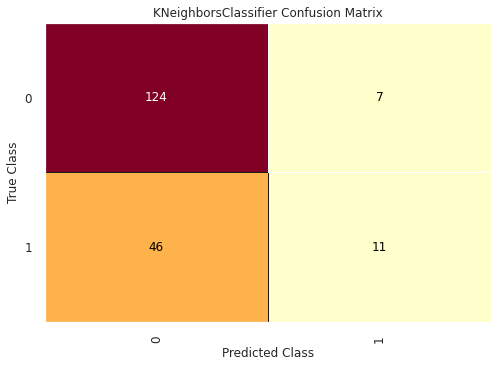

Classifier = Linear SVM, Score (test, accuracy) = 69.68,
F1 SCORE = 0.40,


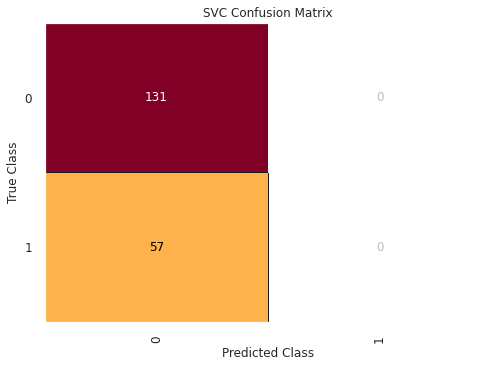

Classifier = RBF SVM, Score (test, accuracy) = 69.68,
F1 SCORE = 0.56,


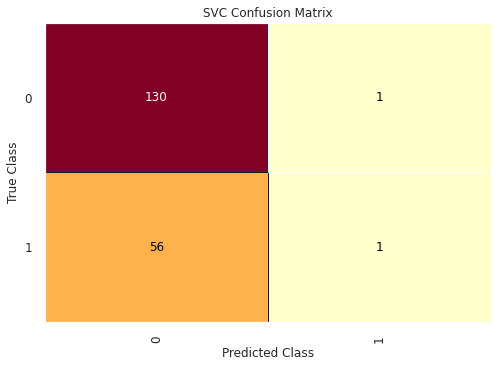

Classifier = Decision Tree, Score (test, accuracy) = 68.62,
F1 SCORE = 0.62,


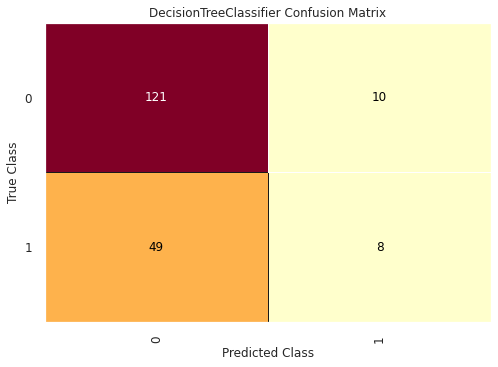

Classifier = Random Forest, Score (test, accuracy) = 69.68,
F1 SCORE = 0.49,


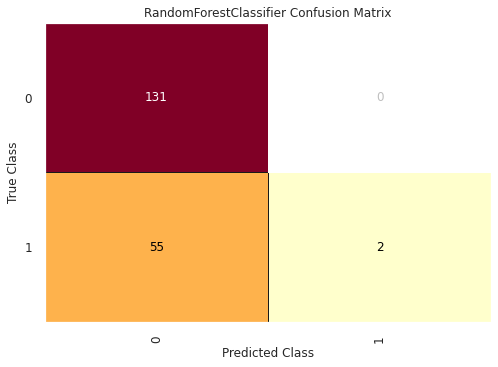

Classifier = Neural Net, Score (test, accuracy) = 69.68,
F1 SCORE = 0.48,


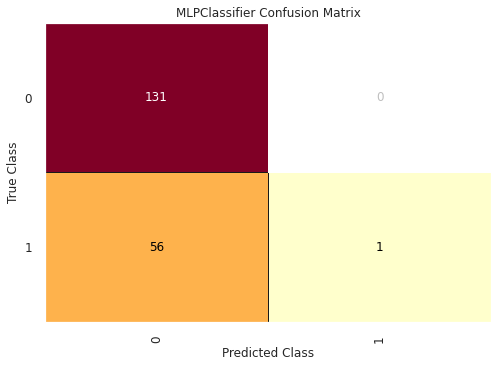

Classifier = AdaBoost, Score (test, accuracy) = 70.21,
F1 SCORE = 0.61,


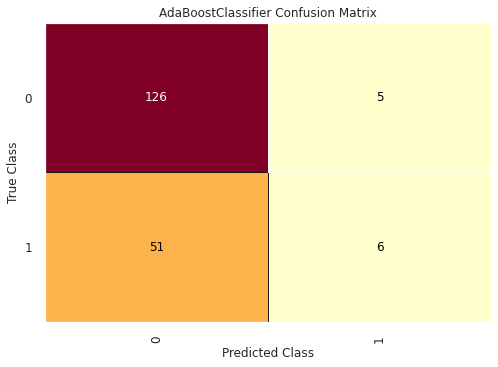

Classifier = Naive Bayes, Score (test, accuracy) = 68.09,
F1 SCORE = 0.48,


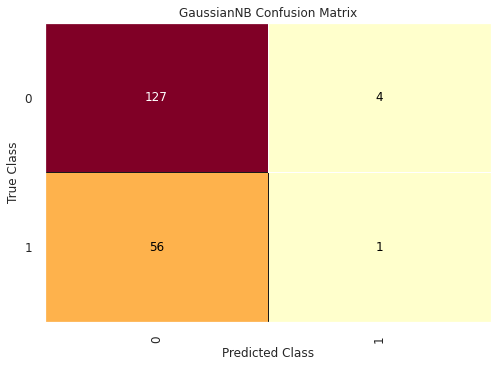

Classifier = QDA, Score (test, accuracy) = 68.09,
F1 SCORE = 0.48,


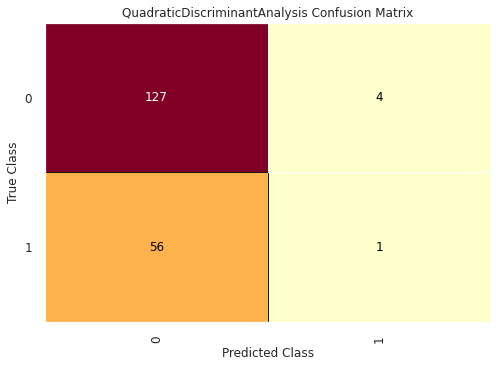

--------------------------------------------------------------------------------
Best --> Classifier = Nearest Neighbors, Score (test, accuracy) = 71.81
--------------------------------------------------------------------------------
Classifier = Nearest Neighbors, Score (test, accuracy) = 75.53,
F1 SCORE = 0.76,


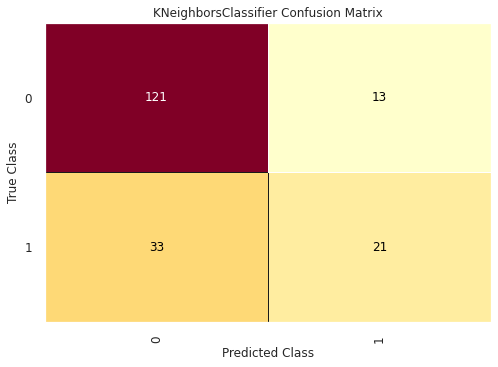

Classifier = Linear SVM, Score (test, accuracy) = 71.28,
F1 SCORE = 0.40,


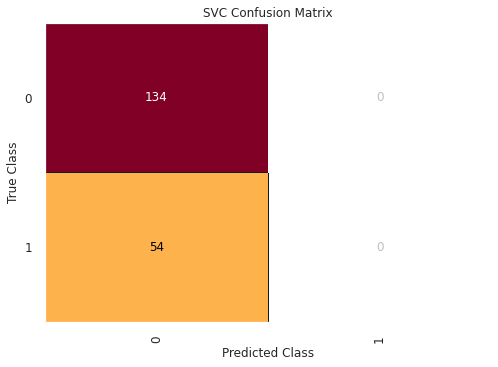

Classifier = RBF SVM, Score (test, accuracy) = 71.81,
F1 SCORE = 0.56,


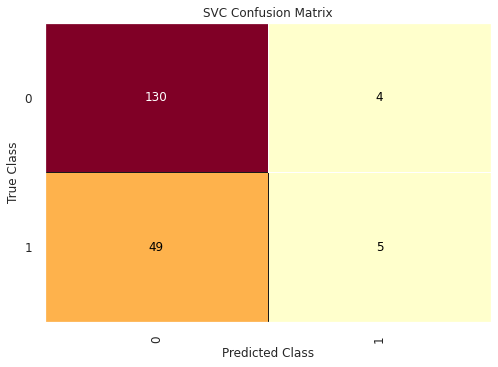

Classifier = Decision Tree, Score (test, accuracy) = 71.28,
F1 SCORE = 0.55,


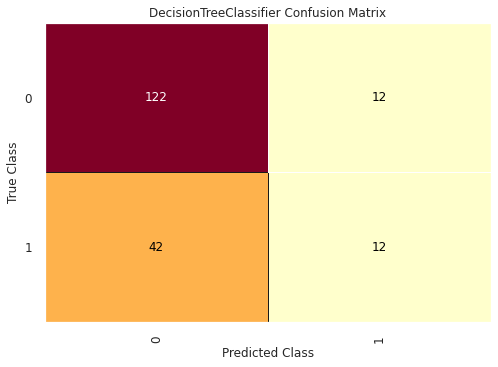

Classifier = Random Forest, Score (test, accuracy) = 71.28,
F1 SCORE = 0.53,


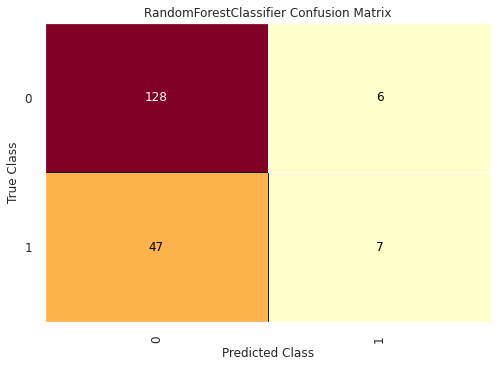

Classifier = Neural Net, Score (test, accuracy) = 72.87,
F1 SCORE = 0.46,


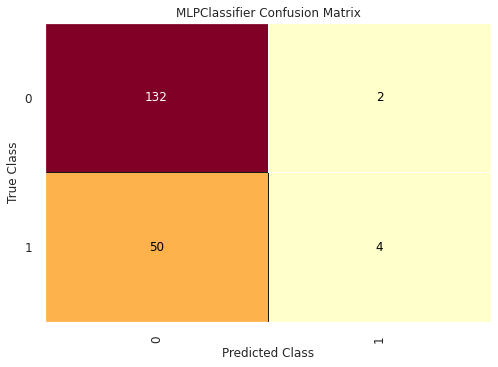

Classifier = AdaBoost, Score (test, accuracy) = 68.09,
F1 SCORE = 0.55,


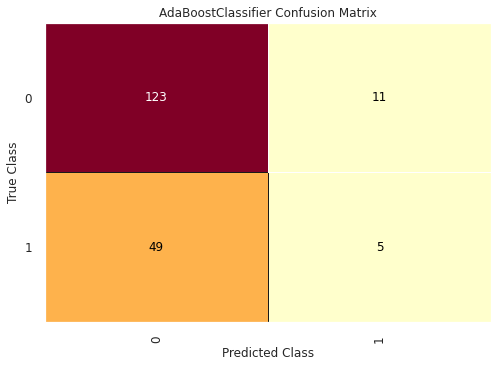

Classifier = Naive Bayes, Score (test, accuracy) = 71.81,
F1 SCORE = 0.46,


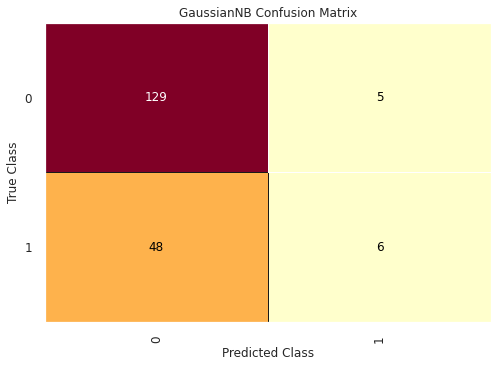

Classifier = QDA, Score (test, accuracy) = 73.40,
F1 SCORE = 0.46,


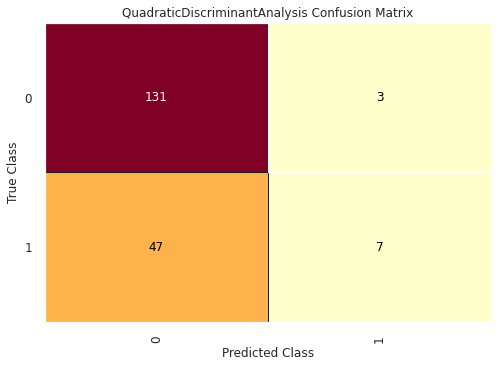

--------------------------------------------------------------------------------
Best --> Classifier = Nearest Neighbors, Score (test, accuracy) = 75.53
--------------------------------------------------------------------------------
Classifier = Nearest Neighbors, Score (test, accuracy) = 70.74,
F1 SCORE = 0.74,


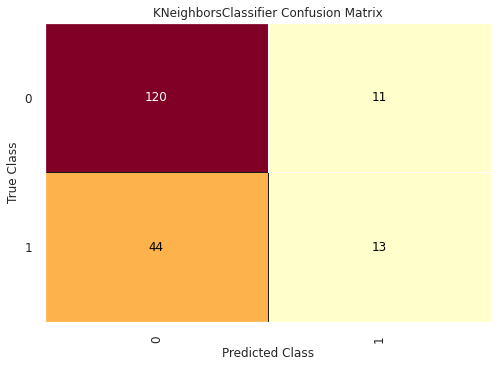

Classifier = Linear SVM, Score (test, accuracy) = 69.68,
F1 SCORE = 0.40,


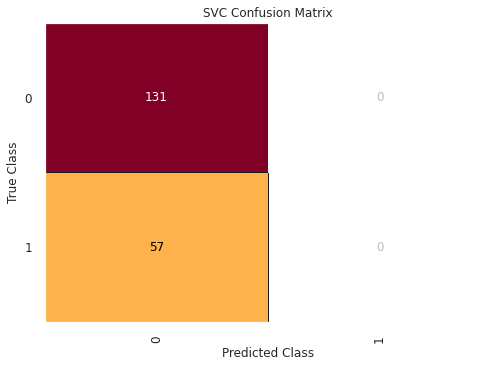

Classifier = RBF SVM, Score (test, accuracy) = 68.62,
F1 SCORE = 0.84,


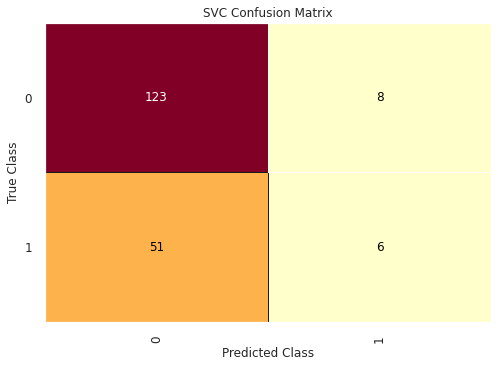

Classifier = Decision Tree, Score (test, accuracy) = 69.68,
F1 SCORE = 0.51,


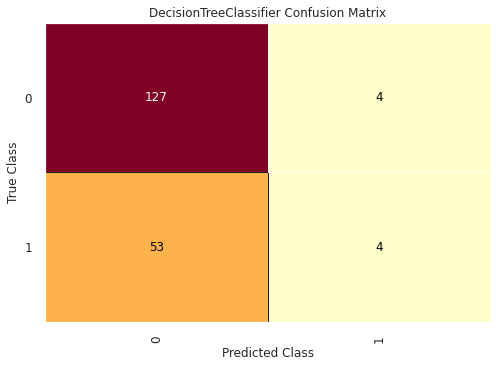

Classifier = Random Forest, Score (test, accuracy) = 70.74,
F1 SCORE = 0.51,


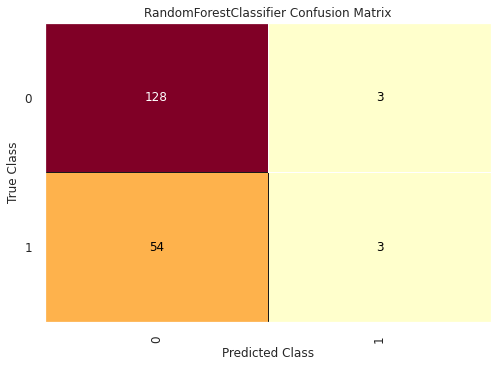

Classifier = Neural Net, Score (test, accuracy) = 70.21,
F1 SCORE = 0.49,


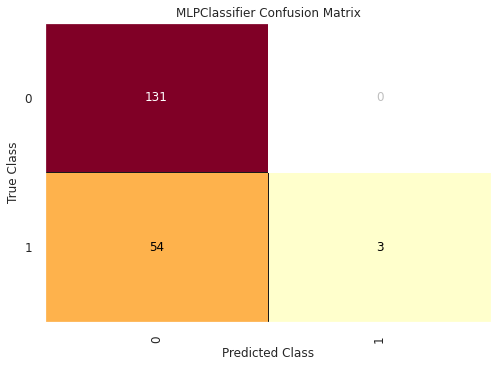

Classifier = AdaBoost, Score (test, accuracy) = 68.09,
F1 SCORE = 0.62,


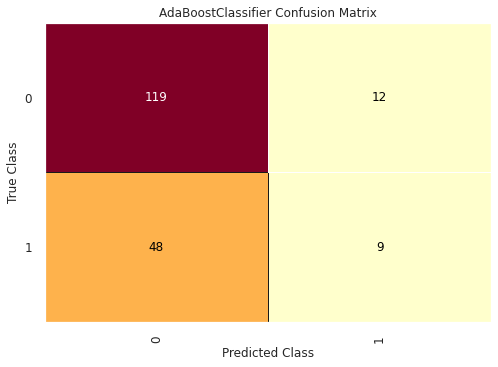

Classifier = Naive Bayes, Score (test, accuracy) = 67.02,
F1 SCORE = 0.50,


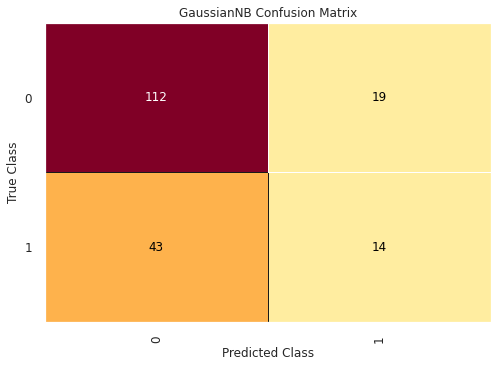

Classifier = QDA, Score (test, accuracy) = 48.40,
F1 SCORE = 0.49,


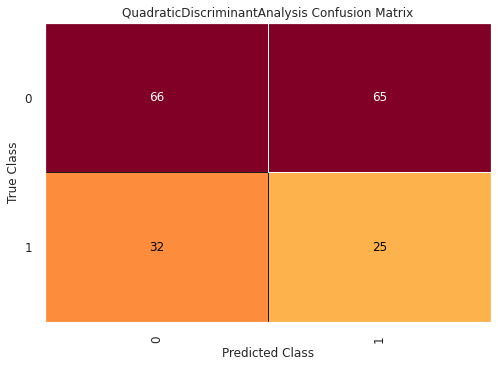

--------------------------------------------------------------------------------
Best --> Classifier = Nearest Neighbors, Score (test, accuracy) = 70.74
--------------------------------------------------------------------------------
Classifier = Nearest Neighbors, Score (test, accuracy) = 69.15,
F1 SCORE = 0.73,


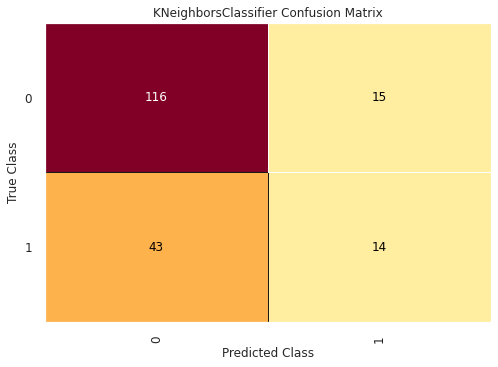

Classifier = Linear SVM, Score (test, accuracy) = 69.68,
F1 SCORE = 0.40,


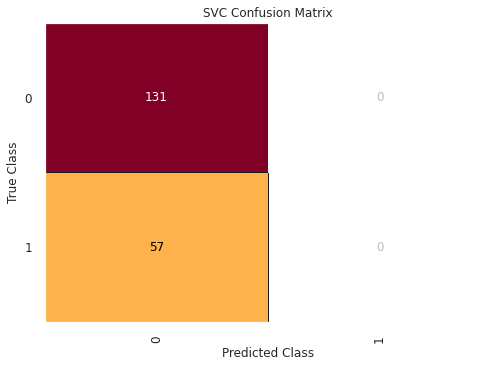

Classifier = RBF SVM, Score (test, accuracy) = 68.09,
F1 SCORE = 0.73,


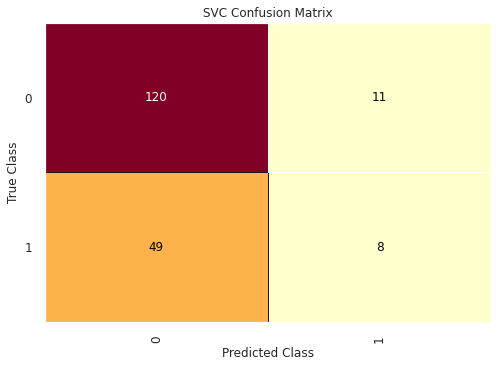

Classifier = Decision Tree, Score (test, accuracy) = 70.21,
F1 SCORE = 0.63,


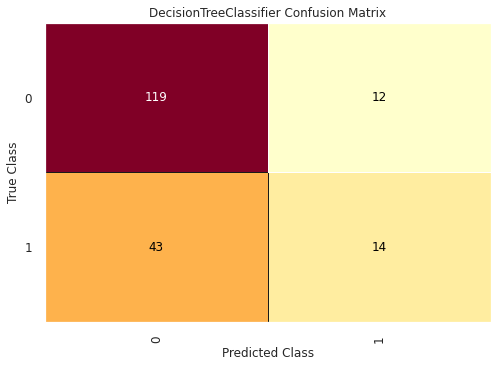

Classifier = Random Forest, Score (test, accuracy) = 71.28,
F1 SCORE = 0.51,


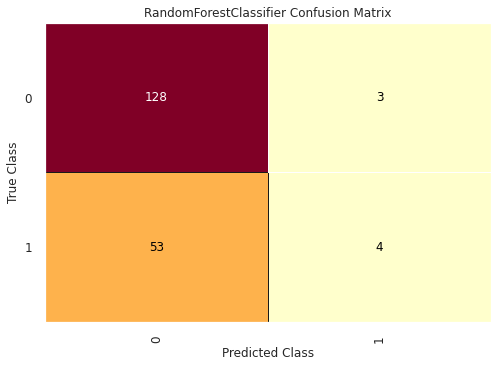

Classifier = Neural Net, Score (test, accuracy) = 70.21,
F1 SCORE = 0.46,


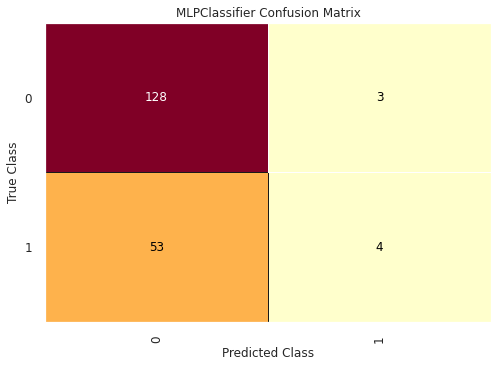

Classifier = AdaBoost, Score (test, accuracy) = 72.87,
F1 SCORE = 0.58,


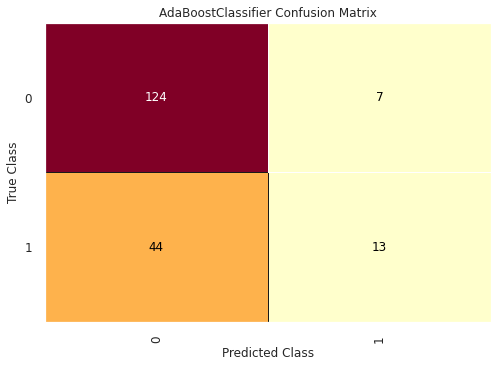

Classifier = Naive Bayes, Score (test, accuracy) = 69.15,
F1 SCORE = 0.47,


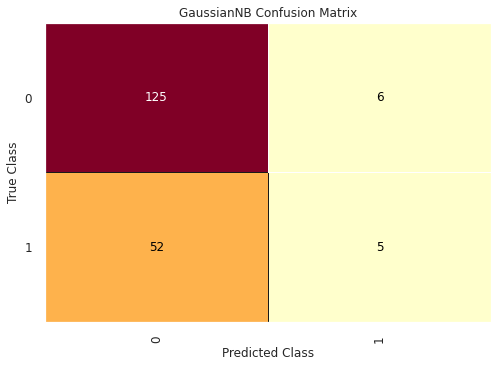

Classifier = QDA, Score (test, accuracy) = 68.09,
F1 SCORE = 0.50,


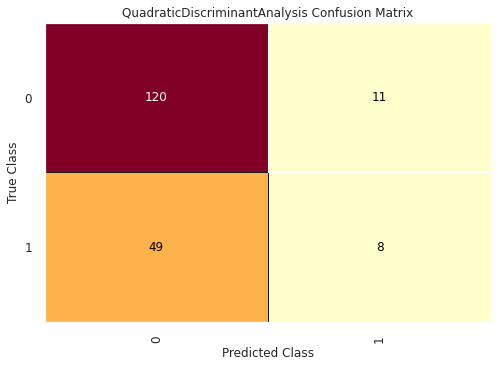

--------------------------------------------------------------------------------
Best --> Classifier = AdaBoost, Score (test, accuracy) = 72.87
--------------------------------------------------------------------------------


In [ ]:
df_ml = data[['Calories','Avg steps per km','VeryActiveDistance','TotalMinutes','In lockdown_Yes']].copy()
featureTransformation(df_ml);

df_ml = data[['Calories','Avg steps per km','VeryActiveDistance','TotalMinutes','In lockdown_Yes']].copy()
featureTransformation(df_ml);
 
df_ml = data[['TrackerDistance','LoggedActivitiesDistance','VeryActiveDistance','ModeratelyActiveDistance','LightActiveDistance','LightlyActiveMinutes','SedentaryMinutes','Calories','TotalMinutes','Active minutes','Avg steps per km','In lockdown_Yes']].copy()
featureTransformation(df_ml);
 
df_ml = data[['TrackerDistance','LoggedActivitiesDistance','VeryActiveDistance','SedentaryMinutes','Calories','TotalMinutes','Active minutes','Avg steps per km','In lockdown_Yes']].copy()
featureTransformation(df_ml);
 


Classifier = Nearest Neighbors, Score (test, accuracy) = 63.83,
F1 SCORE = 0.65,


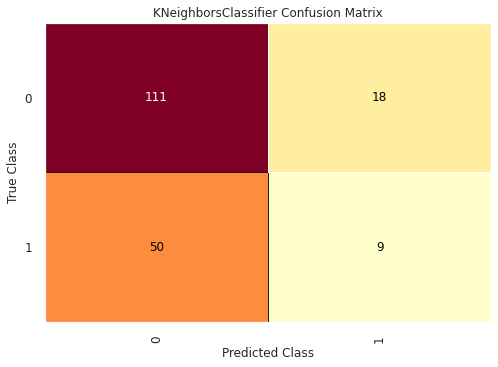

Classifier = Linear SVM, Score (test, accuracy) = 68.62,
F1 SCORE = 0.41,


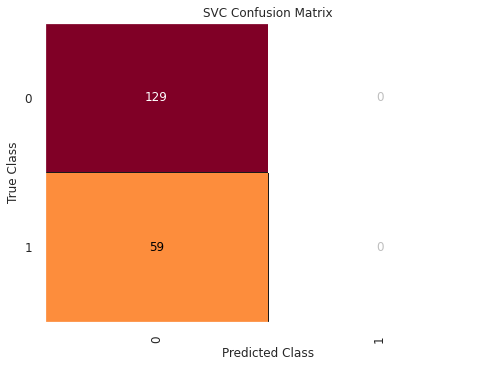

Classifier = RBF SVM, Score (test, accuracy) = 66.49,
F1 SCORE = 0.94,


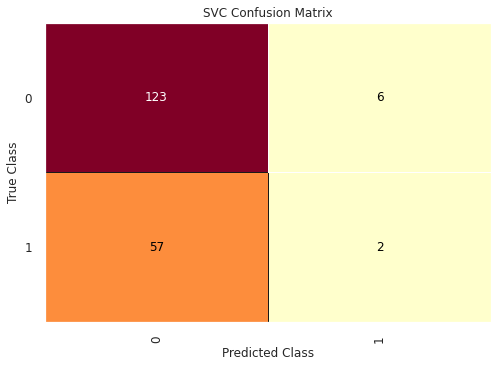

Classifier = Decision Tree, Score (test, accuracy) = 71.28,
F1 SCORE = 0.61,


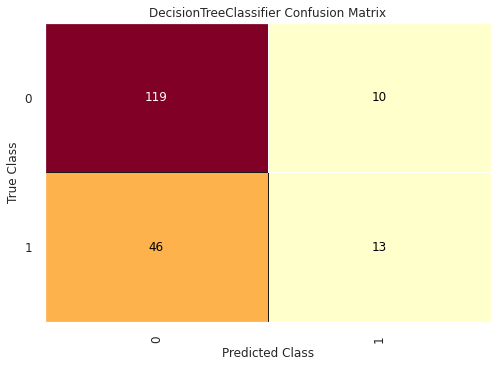

Classifier = Random Forest, Score (test, accuracy) = 69.68,
F1 SCORE = 0.47,


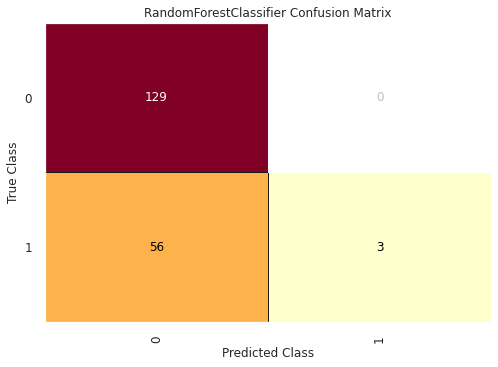

Classifier = Neural Net, Score (test, accuracy) = 64.89,
F1 SCORE = 0.66,


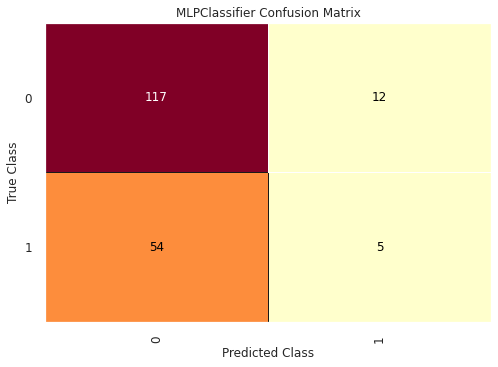

Classifier = AdaBoost, Score (test, accuracy) = 68.09,
F1 SCORE = 0.64,


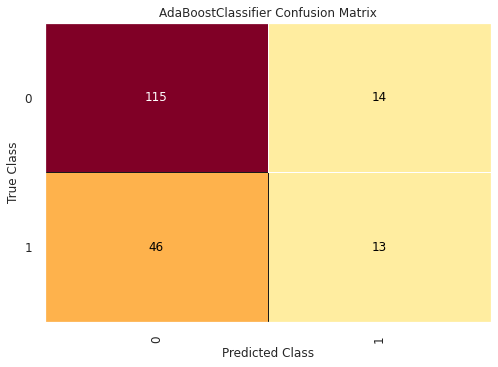

Classifier = Naive Bayes, Score (test, accuracy) = 68.09,
F1 SCORE = 0.58,


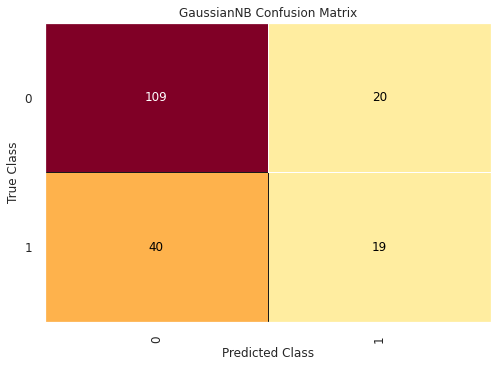

Classifier = QDA, Score (test, accuracy) = 60.11,
F1 SCORE = 0.55,


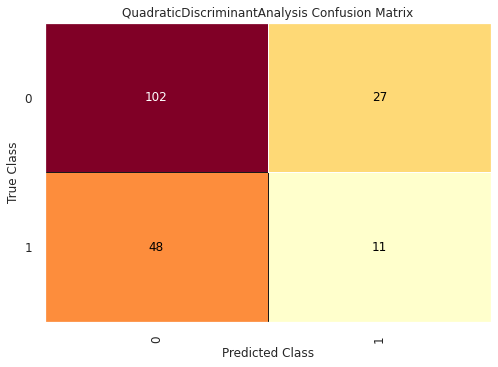

--------------------------------------------------------------------------------
Best --> Classifier = Decision Tree, Score (test, accuracy) = 71.28
--------------------------------------------------------------------------------


In [ ]:
featureTransformation(data)

*** Best accuracy score using Mueller Classifier are for the following columns Calories, Avg steps per km, VeryActiveDistance, TotalMinutes, In lockdown_Yes ***


In [ ]:
len(X_train),len(y_train)

(752, 752)

# Upsampling

In [ ]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print(imblearn.__version__)

oversample = RandomOverSampler(sampling_strategy='minority')
X_train_os_res, y_train_os_res = oversample.fit_sample(X_train, y_train)
print(Counter(y_train_os_res))

0.4.3
Counter({2414.2093023255816: 10, 52.0: 10, 2369.0666666666666: 7, 2401.9777777777776: 7, 2284.732558139535: 6, 2434.693181818182: 5, 2337.0: 5, 2357.4: 4, 2420.16: 4, 2280.1875: 4, 1922.0: 4, 2225.0: 4, 1985.0: 3, 1788.0: 3, 1963.7777777777778: 3, 2489.0: 3, 2463.0: 3, 2400.915254237288: 3, 2403.304347826087: 3, 2383.0: 3, 2093.0: 3, 2324.0: 3, 1995.0: 3, 2095.0: 3, 2194.0: 3, 2361.0: 3, 2105.0: 3, 2066.0: 3, 1776.0: 2, 1921.0: 2, 1827.0: 2, 1970.0: 2, 1898.0: 2, 1947.0: 2, 2004.0: 2, 1990.0: 2, 1819.0: 2, 1821.0: 2, 1740.0: 2, 1463.0: 2, 1554.0: 2, 1604.0: 2, 1401.0: 2, 1655.0: 2, 1370.0: 2, 2806.0: 2, 2344.0: 2, 2498.0: 2, 3328.0: 2, 1725.0: 2, 1742.0: 2, 2318.730769230769: 2, 2220.0: 2, 2499.0: 2, 2638.0: 2, 2752.0: 2, 1431.0: 2, 1667.0: 2, 1916.0: 2, 1593.0: 2, 1692.0: 2, 1698.0: 2, 2124.0: 2, 1632.0: 2, 1481.0: 2, 1878.0: 2, 1780.0: 2, 1972.0: 2, 1630.0: 2, 2010.0: 2, 1882.0: 2, 1946.0: 2, 1529.0: 2, 2094.0: 2, 2241.0: 2, 1906.0: 2, 1908.0: 2, 2044.0: 2, 1638.0: 2, 1397.0: 2

In [ ]:
len(X_train_os_res),len(y_train_os_res)

(761, 761)

# Downsampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_os_res, y_train_os_res = oversample.fit_sample(X_train, y_train)
print(Counter(y_train_os_res))

Counter({2414.2093023255816: 10, 52.0: 10, 2369.0666666666666: 7, 2401.9777777777776: 7, 2284.732558139535: 6, 2434.693181818182: 5, 2337.0: 5, 2357.4: 4, 2420.16: 4, 2280.1875: 4, 1922.0: 4, 2225.0: 4, 1985.0: 3, 1788.0: 3, 1963.7777777777778: 3, 2489.0: 3, 2463.0: 3, 2400.915254237288: 3, 2403.304347826087: 3, 2383.0: 3, 2093.0: 3, 2324.0: 3, 1995.0: 3, 2095.0: 3, 2194.0: 3, 2361.0: 3, 2105.0: 3, 2066.0: 3, 1776.0: 2, 1921.0: 2, 1827.0: 2, 1970.0: 2, 1898.0: 2, 1947.0: 2, 2004.0: 2, 1990.0: 2, 1819.0: 2, 1821.0: 2, 1740.0: 2, 1463.0: 2, 1554.0: 2, 1604.0: 2, 1401.0: 2, 1655.0: 2, 1370.0: 2, 2806.0: 2, 2344.0: 2, 2498.0: 2, 3328.0: 2, 1725.0: 2, 1742.0: 2, 2318.730769230769: 2, 2220.0: 2, 2499.0: 2, 2638.0: 2, 2752.0: 2, 1431.0: 2, 1667.0: 2, 1916.0: 2, 1593.0: 2, 1692.0: 2, 1698.0: 2, 2124.0: 2, 1632.0: 2, 1481.0: 2, 1878.0: 2, 1780.0: 2, 1972.0: 2, 1630.0: 2, 2010.0: 2, 1882.0: 2, 1946.0: 2, 1529.0: 2, 2094.0: 2, 2241.0: 2, 1906.0: 2, 1908.0: 2, 2044.0: 2, 1638.0: 2, 1397.0: 2, 1570

# Gini score

In [ ]:
!pip install scikit-optimize

Index(['Calories', 'Avg steps per km', 'VeryActiveDistance', 'TotalMinutes',
       'In lockdown_Yes'],
      dtype='object')
0.6851063829787234 OrderedDict([('max_depth', 45), ('n_estimators', 334)])
Index(['Calories', 'Avg steps per km', 'VeryActiveDistance', 'TotalMinutes',
       'In lockdown_Yes'],
      dtype='object')


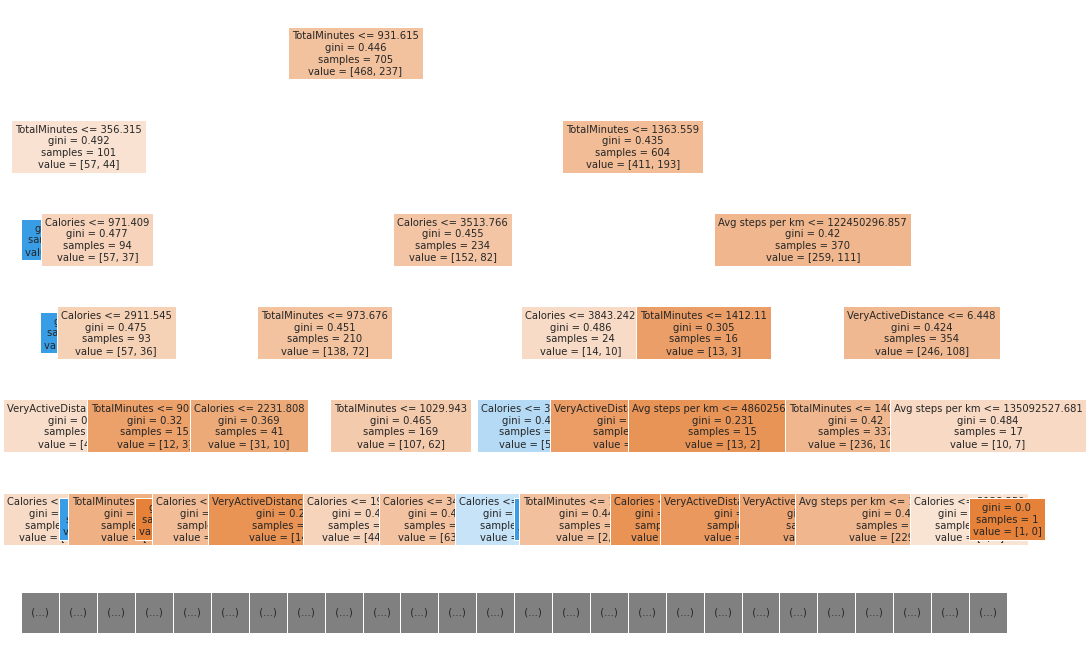

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn import svm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn import tree

import sklearn.metrics as metrics
import skopt

df_ml = data[['Calories','Avg steps per km','VeryActiveDistance','TotalMinutes','In lockdown_Yes']].copy()
df_ml.drop(columns ='In lockdown_Yes')
fn=df_ml.columns
print(fn)
X = df_ml.drop('In lockdown_Yes', axis=1)
y = df_ml['In lockdown_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

X_train.head()
params = {'n_estimators': (5,400),
          'max_depth': (3, 50)}

optimiser = BayesSearchCV(clf, params, n_jobs=-1, n_iter=10)
opt = BayesSearchCV( svm.SVC(), { 'C': Real(1e-6, 1e+6, prior='log-uniform'), 'gamma': Real(1e-6, 1e+1, prior='log-uniform'), 'degree': Integer(1,8), 'kernel': Categorical(['linear', 'poly', 'rbf']), }, n_iter=32 )
#executes bayesian optimization

optimiser.fit(X_train, y_train)

print(optimiser.score(X_test, y_test), optimiser.best_params_)

clf.fit(X_train, y_train)
pred = clf.predict(X_train)
fn=df_ml.columns
print(fn)


fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize=(18, 12))
tree.plot_tree(clf.estimators_[0],
               feature_names = fn, 
               max_depth=5, fontsize=10,
               filled = True);
fig.savefig('clf_individualtree.png')

# Visualiazation (slider)

In [ ]:
pip install git+https://github.com/holoviz/hvplot.git

  Cloning https://github.com/holoviz/hvplot.git to /tmp/pip-req-build-7dtjtq1v
  Running command git clone -q https://github.com/holoviz/hvplot.git /tmp/pip-req-build-7dtjtq1v
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
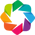

In [ ]:
import hvplot.pandas
import panel as pn
import holoviews as hv
hv.extension('bokeh')
# select_origin =pn.widgets.Select(options=['Yes','No'],name ='In lockdown_Yes')
select_cyl=pn.widgets.IntSlider(name='VeryActiveDistance Increment',start=1,end =10,step=1)
@pn.depends(select_cyl)
def exp_plot(select_cyl):
  return df_ml[(df_ml['VeryActiveDistance'] >= select_cyl)].sort_values(by='Calories').hvplot(x='Calories',y='VeryActiveDistance')
pn.Column(select_cyl,exp_plot).embed()


# Summary
  * Performed Change in data distribution.  
  * Performed Upsampling and Downsampling.  
  * Identified the Gini Score F1 Score and R2 Score.  
  * Identified GradientBoostingRegressor model as the most accurate.  
  * Identified  NearestNeighbourClassifier model as the most accurate.  
  * Using hvplot library visualization of data distibution using slider.  